# Distance map prediction

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from crops import make_batches

In [6]:
train_domains = np.loadtxt('../../data/our_input/train_domains.csv', dtype='O')

inp, out = {}, {}
for i in range(5):
    inp[train_domains[i]] = torch.load(f'../../data/our_input/tensors/{train_domains[i]}_X.pt')
    out[train_domains[i]] = torch.load(f'../../data/our_input/distance_maps/distance_maps32/{train_domains[i]}.pt')
    
    print(train_domains[i], inp[train_domains[i]].shape)

1zv1A00 torch.Size([569, 59, 59])
3t6pA02 torch.Size([569, 66, 66])
2ekfA01 torch.Size([569, 46, 46])
3q8gA01 torch.Size([569, 79, 79])
3hy5A01 torch.Size([569, 101, 101])


In [7]:
ex_i, ex_o = make_batches(inp['3q8gA01'], out['3q8gA01'])

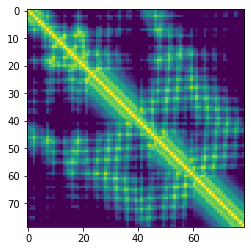

In [10]:
plt.imshow(out['3q8gA01'], 'viridis_r');

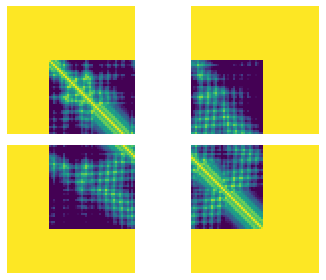

In [23]:
fig, ax = plt.subplots(2, 2)

for i in range(2):
    for j in range(2):
        ax[i, j].imshow(ex_o[i * 2 + j], 'viridis_r');
        ax[i, j].axis('off')
fig.tight_layout()

In [13]:
np.nonzero(ex_o[0])

tensor([[27, 21],
        [27, 22],
        [27, 23],
        ...,
        [63, 61],
        [63, 62],
        [63, 63]])

In [18]:
def unpad_crop(crop, label):
    non_zero_ind = np.nonzero(label)
    
    if len(non_zero_ind) == 0:
        return crop
    else:
        i0, imax = torch.min(non_zero_ind[:, 0]), torch.max(non_zero_ind[:, 0])
        j0, jmax = torch.min(non_zero_ind[:, 1]), torch.max(non_zero_ind[:, 1])
        
        unpadded = torch.empty((imax - i0 + 1, jmax - j0 + 1))
        
        for (i, j) in non_zero_ind:
            unpadded[i - i0, j - j0] = crop[i, j]
    return unpadded

In [20]:
a = unpad_crop(ex_o[0], ex_o[0])

torch.Size([37, 43])
torch.Size([37, 36])
torch.Size([42, 43])
torch.Size([42, 36])


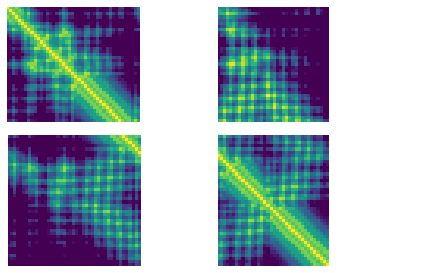

In [27]:
fig, ax = plt.subplots(2, 2)

for i in range(2):
    for j in range(2):
        a = unpad_crop(ex_o[i * 2 + j], ex_o[i * 2 + j])
        ax[i, j].imshow(a, 'viridis_r');
        ax[i, j].axis('off')
        ax[i, j].set_xlim(0, 64)
        print(a.shape)
fig.tight_layout()

In [64]:
def predict_and_glue(model, domain, random_state=1):
    
    X = torch.load(f'../../data/our_input/tensors/{domain}_X.pt')
    Y = torch.load(f'../../data/our_input/distance_maps/distance_maps32/{domain}.pt')
    
    L = Y.shape[1]

    if L % 64 == 0 and random_state % 2 != 0:
        k = L // 64
    else:
        k = L // 64 + 1
    
    i, o = make_batches(X, Y, random_state=random_state)
    preds = model.predict(i)
    #preds = o
    
    dist_map = torch.empty((L, L), dtype=torch.long)
    
    i0 = 0
    for i in range(k):
        j0 = 0
        for j in range(k):
            unpadded = unpad_crop(preds[i * k + j], o[i * k + j])
            imax, jmax = unpadded.shape
            dist_map[i0:(i0 + imax), j0:(j0 + jmax)] = unpadded
            j0 += jmax
        i0 += imax
    return dist_map

In [97]:
def predict_distmap(model, domain, iterations=4):
    
    distmaps = torch.tensor([], dtype=torch.long)
    for i in range(iterations):
        pred = predict_and_glue(model, domain, random_state=1618+i)
        distmaps = torch.cat((distmaps, pred.view(1, pred.shape[0], pred.shape[0])))
    
    return torch.round(torch.mean(distmaps.to(torch.float), axis=0)).to(torch.long)

In [98]:
aa = predict_distmap('', '3q8gA01')

In [99]:
aa.shape

torch.Size([79, 79])

In [100]:
aa

tensor([[ 1,  7,  9,  ..., 31, 31, 31],
        [ 7,  1,  7,  ..., 29, 31, 31],
        [ 9,  7,  1,  ..., 30, 31, 31],
        ...,
        [31, 29, 30,  ...,  1,  6,  9],
        [31, 31, 31,  ...,  6,  1,  6],
        [31, 31, 31,  ...,  9,  6,  1]])

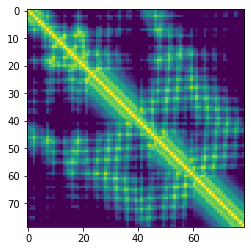

In [101]:
plt.imshow(aa, cmap='viridis_r');

In [72]:
for d in inp:
    pg = predict_and_glue('', d)
    print(torch.sum(pg != out[d]))

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
